## Making plots to compare to the Holden et al. burn severity paper
"We calculated the ‘fire severity tolerance’ for each taxon as the average dNBR of the sites in which it was observed. We computed fire severity tolerance based on (1) presence/absence data and (2) weighted by the relative abundance of the taxon at the sites in which it was observed. Although these values were similar for most fungal taxa, to be conservative we present the fire severity tolerance based on the presence/absence data."

In [1]:
# Loading required packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(dplyr)
library(wesanderson)
library(RColorBrewer)


Attaching package: ‘dplyr’

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
d = psmelt(ps.norm)

In [3]:
# This approach groups by each OTU
df = d %>%
    filter(!(Phylum %in% c("","unidentified")))%>%
    group_by(Site_ID,Veg_Comm,Land_Class,Phylum,Class,Order,Family,Genus,Species,OTU,CBI,RBR,Burn_Severity_Index,Moisture_Regime)%>%
    summarize(TaxPresent = ifelse(sum(Abundance)>0,1,0),Abundance=sum(Abundance))%>%
    filter(TaxPresent>0)%>%
    group_by(Land_Class,Phylum,Class,Order,Family,Genus,Species,OTU)%>%
    summarize(MnWtCBI=sum(CBI*Abundance),MeanCBI=mean(CBI),MeanRBR=mean(RBR),MeanBSI=mean(Burn_Severity_Index), MeanMoisture=mean(as.numeric(paste(Moisture_Regime))),Count=n())
# This should have taken all samples that are not wetlands or unburned
# And then, it filters out all taxa instances where it is not present (Abundance=0)
# Then, it takes the average burn severity (using different metrics) for each OTU.
# It hangs on to the other information, so we can plot it by phylum, etc.
# It looks for presence/absence at each site, so we don't treat org or min differently.

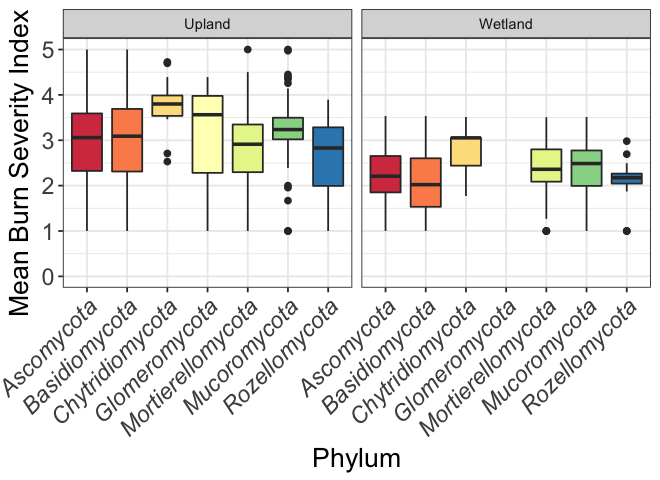

In [4]:
options(repr.plot.width=5.5, repr.plot.height=4)

p = ggplot(df)

p = ggplot(df, aes(x=Phylum, y=MeanBSI, fill=Phylum))
p = p + geom_boxplot()
#p = p + geom_jitter(alpha=0.05)
#p = p + geom_point(data = HoldenData, mapping = aes(x = Phylum, y = MeanRBR), colour="black", size=3, shape=4)
p = p + facet_wrap(~Land_Class)
p = p + scale_fill_manual(values=c(brewer.pal(7,"Spectral")))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=45,hjust=1, face="italic"))
p = p + theme(axis.title = element_text(size=16), axis.text = element_text(size=14))
p = p + guides(colour=FALSE,fill=FALSE) + expand_limits(y=0)
p = p + ylab("Mean Burn Severity Index")
#p = p + geom_text(aes(label=paste("",nTax, sep=""), y = 3.1, angle=90), colour="black")
p

In [5]:
a = aov(MeanBSI~Phylum, data=df[df$Land_Class=="Upland",])
#a = aov(MeanBSI~Phylum, data=df[df$Land_Class=="Wetland",])
Tukey = TukeyHSD(a)
summary(a)
Tukey

              Df Sum Sq Mean Sq F value   Pr(>F)    
Phylum         6   27.6   4.600   4.927 5.02e-05 ***
Residuals   3131 2923.2   0.934                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = MeanBSI ~ Phylum, data = df[df$Land_Class == "Upland", ])

$Phylum
                                         diff         lwr          upr
Basidiomycota-Ascomycota           0.02785738 -0.08176474  0.137479505
Chytridiomycota-Ascomycota         0.89026050  0.19565582  1.584865186
Glomeromycota-Ascomycota           0.08128275 -1.56590467  1.728470161
Mortierellomycota-Ascomycota      -0.12445120 -0.42906090  0.180158502
Mucoromycota-Ascomycota            0.32079704  0.03074993  0.610844146
Rozellomycota-Ascomycota          -0.30662090 -0.86965544  0.256413635
Chytridiomycota-Basidiomycota      0.86240312  0.16556931  1.559236937
Glomeromycota-Basidiomycota        0.05342537 -1.59470329  1.701554026
Mortierellomycota-Basidiomycota   -0.15230858 -0.46196770  0.157350537
Mucoromycota-Basidiomycota         0.29293966 -0.00240594  0.588285258
Rozellomycota-Basidiomycota       -0.33447828 -0.90026057

## Ellen wanted to know if moisture regime looks like CBI.

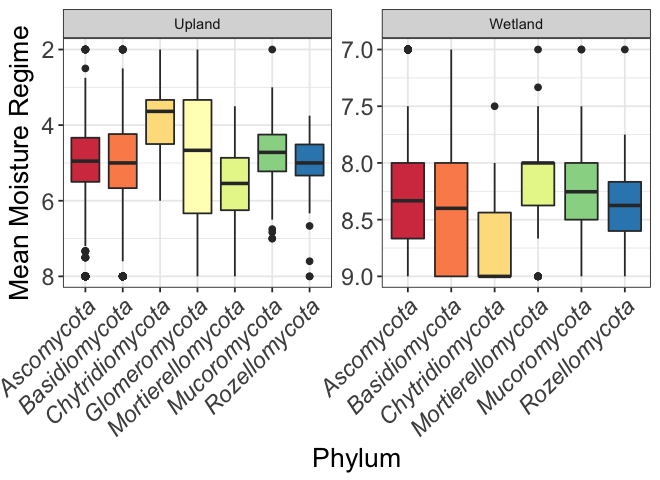

In [6]:
options(repr.plot.width=5.5, repr.plot.height=4)

p = ggplot(df, aes(x=Phylum, y=MeanMoisture, fill=Phylum))
p = p + geom_boxplot()
p = p + facet_wrap(~Land_Class, scales="free")
p = p + scale_fill_manual(values=c(brewer.pal(7,"Spectral")))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=45,hjust=1, face="italic"))
p = p + theme(axis.title = element_text(size=16), axis.text = element_text(size=14))
p = p + guides(colour=FALSE,fill=FALSE) #+ expand_limits(y=0)
p = p + ylab("Mean Moisture Regime") + scale_y_reverse()
p

#### Same patterns as CBI... so what if we stratify CBI analysis by moisture regime?

In [7]:
# This approach groups by each OTU
df = d %>%
    filter(!(Phylum %in% c("","unidentified")))%>%
    filter(Moisture_Regime != 2)%>%
    mutate(Moisture_Regime = paste("Moisture Regime",Moisture_Regime))%>%
    group_by(Site_ID,Veg_Comm,Land_Class,Phylum,Class,Order,Family,Genus,Species,OTU,CBI,RBR,Burn_Severity_Index,Moisture_Regime)%>%
    summarize(TaxPresent = ifelse(sum(Abundance)>0,1,0),Abundance=sum(Abundance))%>%
    filter(TaxPresent>0)%>%
    group_by(Land_Class,Moisture_Regime,Phylum,Class,Order,Family,Genus,Species,OTU)%>%
    summarize(MeanCBI=mean(CBI),MeanRBR=mean(RBR),MeanBSI=mean(Burn_Severity_Index), Count=n())
# This should have taken all samples that are not wetlands or unburned
# And then, it filters out all taxa instances where it is not present (Abundance=0)
# Then, it takes the average burn severity (using different metrics) for each OTU.
# It hangs on to the other information, so we can plot it by phylum, etc.
# It looks for presence/absence at each site, so we don't treat org or min differently.
# Removed moisture regime = 2 because there is only one site with that level.

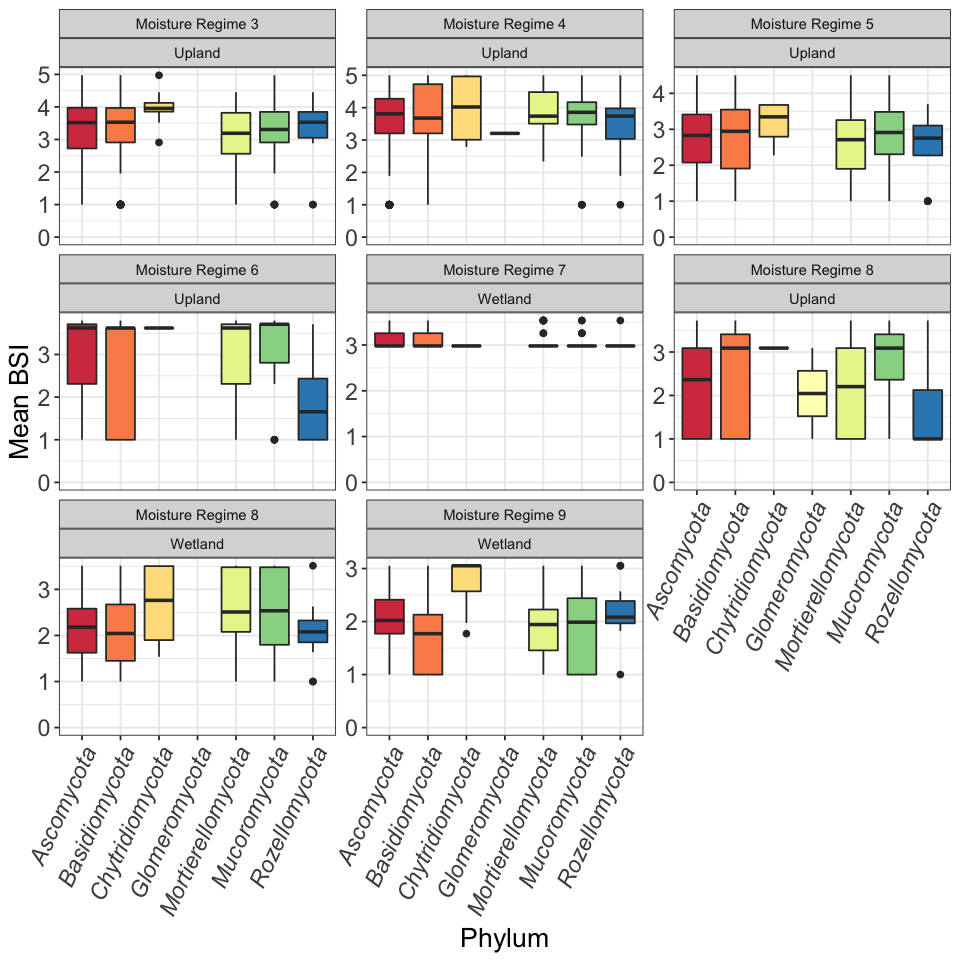

In [8]:
options(repr.plot.width=8, repr.plot.height=8)

p = ggplot(df, aes(x=Phylum, y=MeanBSI, fill=Phylum))
p = p + geom_boxplot()
p = p + facet_wrap(~Moisture_Regime~Land_Class, scales="free_y")
p = p + scale_fill_manual(values=c(brewer.pal(7,"Spectral")))
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(angle=65,hjust=1, face="italic"))
p = p + theme(axis.title = element_text(size=16), axis.text = element_text(size=14))
p = p + guides(colour=FALSE,fill=FALSE) + expand_limits(y=0)
p = p + ylab("Mean BSI")
p